## Kalman Filters for Generator Model
#### Madhusudhan Pandey, with modification by Bernt Lie
#### University of South-Eastern Norway
#### Spring of 2019

#### **Packages and definitions**

##### Packages

In [46]:
# Introducing packages
using DataFrames
using CSV
using Plots; pyplot()
using LaTeXStrings
using JLD
using LinearAlgebra
using NLsolve
using Statistics
#using DifferentialEquations
#using Compat, Random, Distributions

##### Definitions

In [47]:
#figpath = "C:/Users/Bernt_Lie/OneDrive/Documents/researchUSN/Supervisor/MScThesis/Spring2019/Madhusudhan_Pandey/figs/"
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;

#### **Data from Aabjøra generator**
#### Importing data

In [48]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
# ny number of outputs: Ts, TFe
ny = 2
# nu number of inputs: Twc, If, It
nu = 3
#
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end

#### Storing measurements

In [49]:
y_m = [[Ts_m[i],TFe_m[i]] for i in 1:N];

#### Presenting experimental data

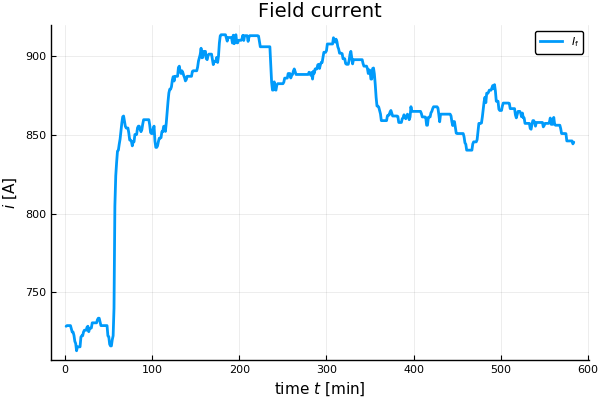

In [50]:
plot(If,lw=LW1,label=L"I_\mathrm{f}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]",title="Field current")

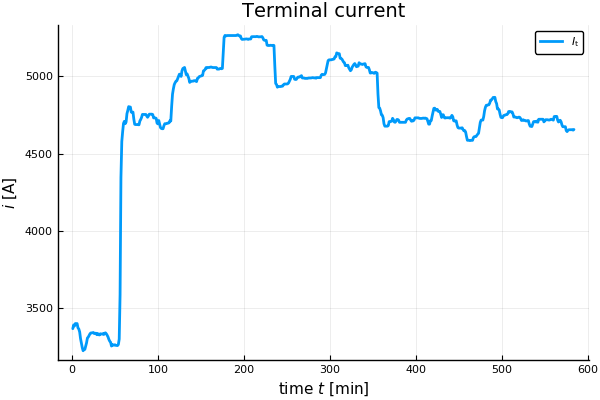

In [21]:
plot(It,lw=LW1,label=L"I_\mathrm{t}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]", title="Terminal current")

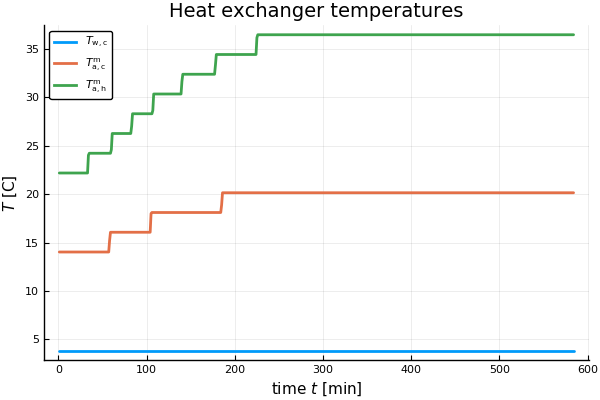

In [22]:
plot(Twc,lw=LW1,label=L"T_\mathrm{w,c}")
plot!(Tac_m,lw=LW1,label=L"T_\mathrm{a,c}^\mathrm{m}")
plot!(Tah_m,lw=LW1,label=L"T_\mathrm{a,h}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Heat exchanger temperatures")

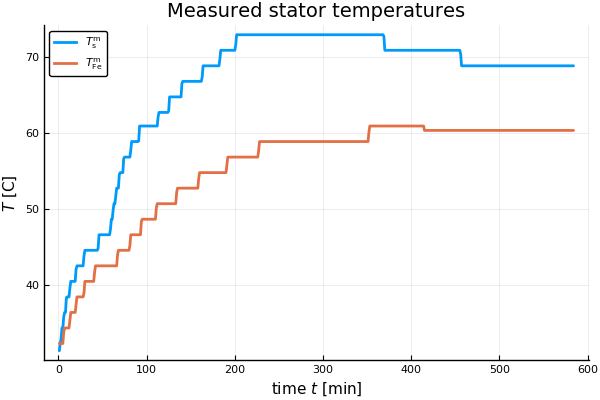

In [23]:
plot(Ts_m,lw=LW1,label=L"T_\mathrm{s}^\mathrm{m}")
plot!(TFe_m,lw=LW1,label=L"T_\mathrm{Fe}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Measured stator temperatures")

#### **Simulation model**
#### Inputs

In [51]:
# If, imported from CSV file
# It, imported from CSV file
# Twc, imported from CSV file
QdFes = 212.
Wdf = 528.
Qdfs = 0.8*Wdf # Efficient heating in air gap due to friction
mdw = 48.51
mda = 44.28;

#### Parameters

In [52]:
pa = 1.01e5 # Atmospheric pressure , Pa
#
# Heat capacities
chpa = 1.012#1.15 # Specific heat capacity air , kJ.kg-1.K-1  
chpw = 4.1813#4.2 # Specific heat capacity water , kJ.kg-1.K-1 
chpCu = 0.385#0.385 # Specific heat capacity copper , kJ.kg-1.K -1 
chpFe = 0.412#0.465 # Specific heat capacity iron , kJ.kg-1.K-1 
#
# Metal massses
mr = 9260. # Mass of copper in rotor , kg
ms = 6827. # Mass of copper in stator , kg
mFe = 71200. # Mass of iron in stator , kg
#
# Specific volumes (inverse of density)
VhCu = 0.112e-3 # Specific volume of copper , m3/kg 
VhFe = 0.127e-3 # Specific volume of iron , m3/kg 
#
# Resulting volumes
Vr = mr*VhCu # Rotor copper volume , m3  
Vs = ms*VhCu # Stator copper volume , m3 
VFe = mFe*VhFe # Stator iron volume , m3 
#
# Heat transfer (heat transfer coefficient x area), fluids to solid
hAax = 55.6 # Heat transfer from air to solid, kW/K
hAwx = 222. # Heat transfer from water to solid, kW/K
#
# Overall heat transfer (overall heat transfer coeffcients x area)
UAx = 1/(1/hAax+1/hAwx) # Overall heat transfer air-to-water, kW/K
UAr2d = 2.96 #2.835  #2.7 # Heat transfer, rotor copper to air gap, kW/K 
UAs2Fe = 18 #19.#20. # Heat transfer, stator copper to stator iron, kW/K 
UAFe2a = 12.87 #13.585 # 14.285 # 14.3 # Heat transfer, rotor iron to hot air, kW/K 
#
# Stanton numbers for heat exchanger
NSta = UAx/chpa/(mda)
NStw = UAx/chpw/(mdw)
NStd = NStw - NSta
#
# Enthalpies of formation
Hha_o = 0. # Enthalpy of formation air, kJ/kg
HhCu_o = 0. # Enthalpy of formation copper, kJ/kg 
HhFe_o = 0. # Enthalpy of formation iron, kJ/kg
#
# Standard state temperatures
Ta_o = 25. # Standard state temperature air, C
TCu_o = 25. # Standard state temperature copper, C
TFe_o = 25. # Standard state temperature iron, C
#
# Copper conductor resistances
Rr = 0.127e-3 # Ohmic resistance, rotor copper, kOhm, at 25 C
Rs = 1.95e-6  # Ohmic resistance, stator copper, kOhm, at 25 C
#
# Vector of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,Qdfs,hAax,hAwx,UAx,NStw,NSta,NStd];

#### Models
##### Algebraic variables

In [53]:
# Given x_k = (Tr,Ts,TFe) at time index k,
# this function returns z_k = (Tac,Tad,Tah) at time index k
function z_k(x_k,k)
    Tr,Ts,TFe = x_k
    function f!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[k]
    end
    return nlsolve(f!,[Ta_o,Ta_o,Ta_o]).zero   
end

z_k (generic function with 1 method)

##### One step ahead state predictor

In [54]:
# Given x_k = (Tr,Ts,TFe) at time index k, z_k = (Tac,Tad,Tah) at time index k
# and wx_k at time index k, this function returns x_kp1 at time index k+1
#
# Sample time for measurements
dt = 60 # Discretization time, s
#
# Number nx of states x; number nz of algebraic variables nz
nx = 3
nz = 3
#
# Prediktor, using Explicit Euler
function x_kp1(x_k,z_k,wx_k,k)
    Tr,Ts,TFe = x_k
    Tac,Tad,Tah = z_k
    wTr,wTs,wTFe = wx_k
    #
    # Vector fields
    fTr = (1.1*Rr*If[k]^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    fTs = (3*Rs*It[k]^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    fTFe = (UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    #
    # Euler integration + addition of discrete state disturbance
    Tr = Tr + dt*fTr + wTr
    Ts = Ts + dt*fTs + wTs
    TFe = TFe + dt*fTFe + wTFe
    return [Tr,Ts,TFe]
end

x_kp1 (generic function with 1 method)

##### Outputs

In [55]:
# Given x_k = (Tr,Ts,TFe), compute output y_k = (Ts,TFe)
function y_k(x_k)
    return [x_k[2],x_k[3]]
end

y_k (generic function with 2 methods)

#### **Statistical description: state disturbance, noise, and initial value**

In [56]:
#
# Statistical description of state disturbance, measurement noise, and initial state
#
# Process state disturbance covariance W and Process state disturbance standard deviation sW
W = diagm(0=>[2^2,2^2,2^2])
sW = sqrt(W)
#
# Measurement noise covariance V and Measurement noise standard deviation sV
V = diagm(0 => [1^2,1^2,1^2,1^2])
sV = sqrt(V)
#
# Initial state
x1 = [28.,Ts_m[1],TFe_m[1]]
#
# Initial state covariance X1 and Initial state standard deviation sX1
#
mux = 10;
X1 = mux*W
sX1 = sqrt(X1);

In [57]:
X1

3×3 Array{Int64,2}:
 40   0   0
  0  40   0
  0   0  40

#### **Ensemble Kalman Filter**
#### Storage arrays and Initialization

In [31]:
# Number of particles np; N measurement data, nx states, nz algebraic variables, ny measurements
np = 50
XX_pr = zeros(nx,N,np) # Priori particles
XX_po = zeros(nx,N,np) # Posteriori particles
ZZ = zeros(nz,N,np) # Best (posteriori) algebraic particles 
YY_pr = zeros(ny,N,np) # Priori output particles
#
# Initialization
#
# Drawing initial state for particles
XX_po[:,1,:] = kron(x1,ones(1,np)) + sX1*randn(nx,np)
XX_pr = XX_po
#
# Computing initial algebraic variables for particles
ZZ[:,1,:] = reduce(hcat,[z_k(XX_po[:,1,p],1) for p in 1:np])
#
# Computing initial noisy outputs for particles
YY_pr[:,1,:] = reduce(hcat,[y_k(XX_pr[:,1,p],ZZ[:,1,p]) for p in 1:np]) + sV*randn(ny,np);

##### Ensemble Kalman Filter

In [516]:
# Loops over data
for k in 2:N
    #
    # Predicting states for every particle
    for p in 1:np
        XX_pr[:,k,p] = x_kp1(XX_po[:,k-1,p],ZZ[:,k-1,p],sW*randn(nx),k-1)
    end
    # Predicting outputs for every particle
    YY_pr[:,k,:] = reduce(hcat,[y_k(XX_pr[:,k,p],z_k(XX_pr[:,k,p],k)) for p in 1:np]) + sV*randn(ny,np);
    # Computing Kalman gain
    Z = cov(XX_pr[:,k,:],YY_pr[:,k,:],dims=2)
    E = cov(YY_pr[:,k,:],dims=2)
    K = Z/E
    # Computing posteriori particles
    for p in 1:np
        XX_po[:,k,p] = XX_pr[:,k,p] + K*(y_m[k]- YY_pr[:,k,p])
    end
    # Updating algebraic variables for every particle
    ZZ[:,k,:] = reduce(hcat,[z_k(XX_po[:,k,p],k) for p in 1:np])
end

##### Mean and standard deviation of quantities

In [517]:
x_pr = mean(XX_pr,dims=3)[:,:,1]
x_pr_s = std(XX_pr,dims=3)[:,:,1]
x_po = mean(XX_po,dims=3)[:,:,1]
x_po_s = std(XX_po,dims=3)[:,:,1]
z = mean(ZZ,dims=3)[:,:,1]
z_s = std(ZZ,dims=3)[:,:,1]
y_pr = mean(YY_pr,dims=3)[:,:,1];
y_pr_s = std(YY_pr,dims=3)[:,:,1];

##### Indices for subsampling measurements

In [32]:
idx = 1:10:N;

##### Plotting particles

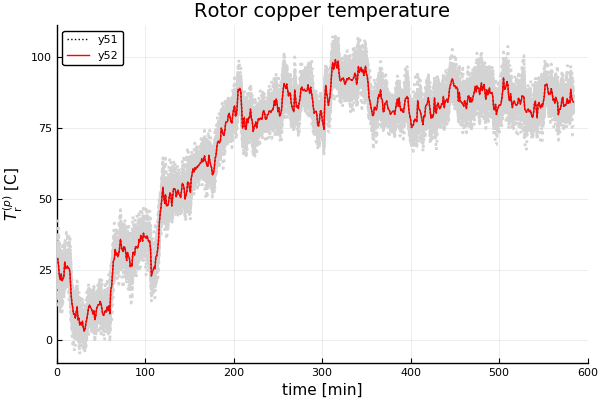

In [519]:
fx1_po = plot()
for p in 1:np
    plot!(fx1_po,XX_po[1,:,p],lw=LW1,ls=LS2,c=:lightgray,label="")
end
plot!(fx1_po,x_po[1,:],lc=:black,lw=1,ls=:dot)#,ribbon=(x_po_s[1,:]),fc=:white,fa=0.8,label=L"\hat{T}_\mathrm{r,k|k}")
plot!(fx1_po,x_pr[1,:],lc=:red,lw=1)#,#ribbon=(x_pr_s[1,:]),fc=:white,fa=0.8,label=L"\hat{T}_\mathrm{r,k|k}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{r}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Rotor copper temperature")

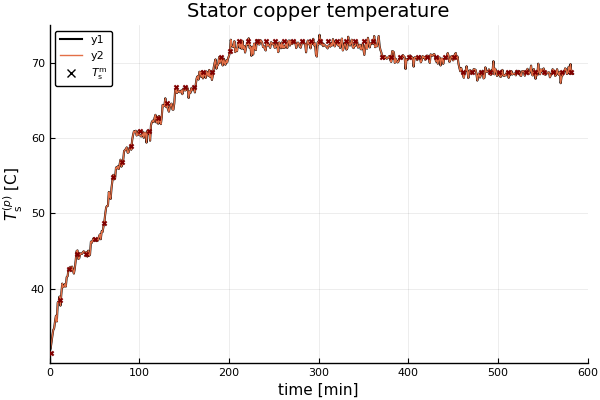

In [520]:
fx2_po = plot()
#for p in 1:np
   # plot!(fx2_po,XX_po[2,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
#end
plot!(fx2_po,x_po[2,:],lc=:black,lw=LW2) #ribbon=(x_po_s[2,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{s,k|k}")
plot!(fx2_po,x_pr[2,:])
plot!(fx2_po,idx,Ts_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{s}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{s}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Stator copper temperature")

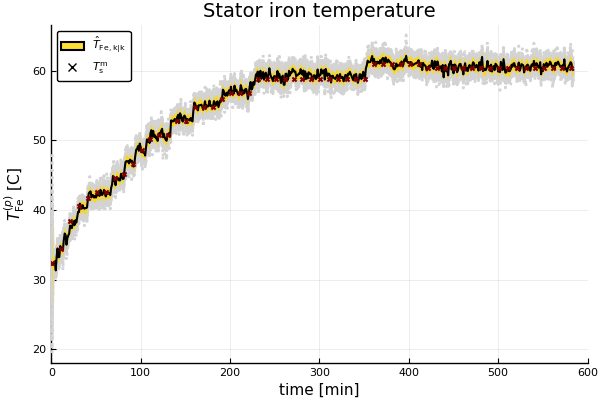

In [521]:
fx3_po = plot()
for p in 1:np
    plot!(fx3_po,XX_po[3,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
end
plot!(fx3_po,x_po[3,:],lc=:black,lw=LW2,ribbon=(x_po_s[3,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{Fe,k|k}")
plot!(fx3_po,idx,TFe_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{s}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{Fe}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Stator iron temperature")

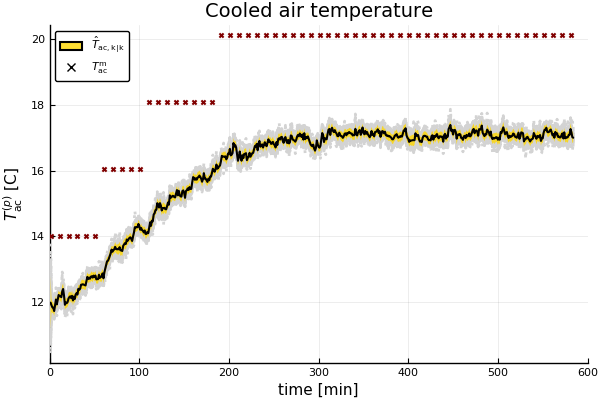

In [522]:
fz1_po = plot()
for p in 1:np
    plot!(fz1_po,ZZ[1,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
end
plot!(fz1_po,z[1,:],lc=:black,lw=LW2,ribbon=(z_s[1,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{ac,k|k}")
plot!(fz1_po,idx,Tac_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{ac}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{ac}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Cooled air temperature")

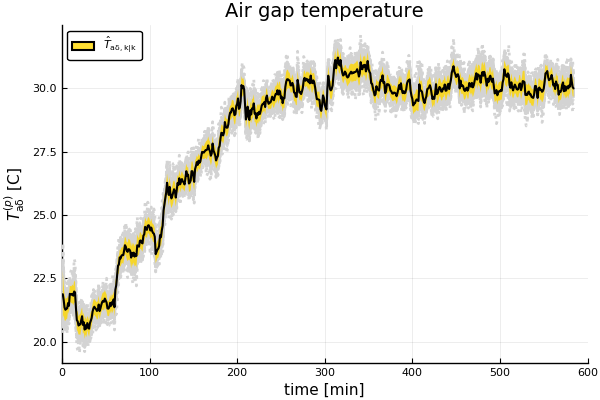

In [523]:
fz2_po = plot()
for p in 1:np
    plot!(fz2_po,ZZ[2,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
end
plot!(fz2_po,z[2,:],lc=:black,lw=LW2,ribbon=(z_s[2,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{a\delta,k|k}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{a\delta}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Air gap temperature")

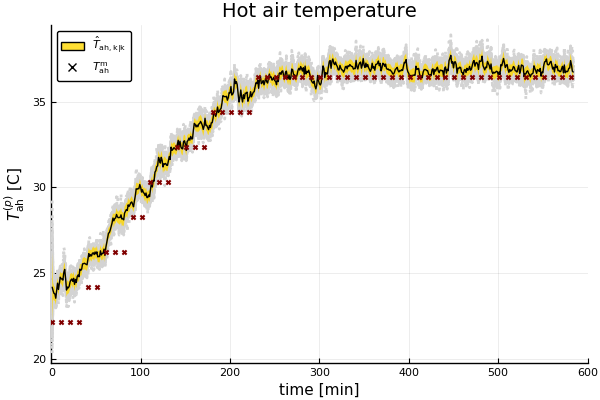

In [524]:
fz3_po = plot()
for p in 1:np
    plot!(fz3_po,ZZ[3,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
end
plot!(fz3_po,z[3,:],lc=:black,ribbon=(z_s[3,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{ah,k|k}")
plot!(fz3_po,idx,Tah_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{ah}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{ah}^{(p)}$ [C]")
plot!(xlim=(0,600),title="Hot air temperature")

#### **Unscented Kalman Filter**
#### Storage arrays and Initialization

In [403]:
# N measurement data, nx states, nz algebraic variables, ny measurements
xu_pr = zeros(nx,N) # Priori states
xu_po = zeros(nx,N) # Posteriori states
zu = zeros(nz,N) # Best (posteriori) algebraic values 
yu_pr = zeros(ny,N) # Priori output values
#
# Standard deviation
xu_pr_s = zeros(nx,N) # Priori state std
xu_po_s = zeros(nx,N) # Posteriori states std
zu_s = zeros(nz,N) # Best (posteriori) algebraic value std 
yu_pr_s = zeros(ny,N) # Priori output value std
#
# Sigma matrices
XXu_pr = zeros(nx,2*nx)
XXu_po = zeros(nx,2*nx)
ZZu = zeros(nz,2*nx)
YYu_pr = zeros(ny,2*nx)
#
# Initialization
#
xu_po[:,1] = x1;
xu_pr[:,1] = x1;
zu[:,1] = z_k(x1,1)
yu_pr[:,1] = y_k(x1);
#
xu_po_s[:,1] = diag(sqrt(X1))
xu_pr_s[:,1] = x_po_s[:,1];

#### Unscented Kalman Filter

In [405]:
# Initializing current covariance matrix
X_po = X1;
# Loops over data
for k in 2:N
    #
    # Finding sigma points XXu_po
    for i in 1:2*nx
        if i<nx+1
            XXu_po[:,i]=xu_po[:,k-1]+cholesky(nx*X_po).U[i,:]
        elseif i>nx
            XXu_po[:,i]=xu_po[:,k-1]-cholesky(nx*X_po).U[i-nx,:]
        end
    end
    #XX = cholesky(nx*X_po).L
    #XXu_po[:,1:nx] = xu_po[:,k-1] .+ XX
    #XXu_po[:,nx+1:2nx] = xu_po[:,k-1] .- XX
    
    # Finding sigma points ZZu
    for i in 1:2*nx
        ZZu[:,i] = z_k(XXu_po[:,i],k-1)
    end
    #
    # Predicting sigma states XXu_pr and outputs YYu_pr
    for i in 1:2*nx
        wx = zeros(3)
        XXu_pr[:,i] = x_kp1(XXu_po[:,i],ZZu[:,i],wx,k-1)
    end
    print(XXu_pr)
    print("\n")
    for i in 1:2*nx
        YYu_pr[:,i] = y_k(XXu_pr[:,i])
    end
    # Computing Kalman gain
    Z = cov(XXu_pr,YYu_pr,dims=2,corrected=false)
    E = cov(YYu_pr,dims=2,corrected=false) + V
    K = Z/E
    #
    # Computing means over sigma values and posteriori values
    xu_pr[:,k] = mean(XXu_pr,dims=2)
    yu_pr[:,k] = mean(YYu_pr,dims=2)
    xu_po[:,k] = xu_pr[:,k] + K*(y_m[k] - yu_pr[:,k])
    zu[:,k] = z_k(xu_po[:,k],k)
    # Computing covariances
    X_pr = cov(XXu_pr,dims=2,corrected=false) + W
    print(X_pr)
    X_po = X_pr - K*E*K'
    #print(X_po)
    print("\n")
    X_po = Hermitian(X_po)
    
    # Computing standard deviations
    xu_pr_s[:,k] = diag(sqrt(X_pr))
    xu_po_s[:,k] = diag(sqrt(X_po))
    yu_pr_s[:,k] = std(YYu_pr,dims=2)
    zu_s[:,k] = std(ZZu,dims=2)
end


[39.3955 28.939 29.0036 18.4825 28.939 28.8744; 33.3233 39.7766 37.8244 33.3233 26.87 28.8221; 32.5722 32.9559 42.9062 32.533 32.1493 22.199]
[40.4474 0.096909 0.291233; 0.096909 24.6351 16.402; 0.291233 16.402 39.7869]
[40.3517 29.8373 29.8599 19.3226 29.837 29.8144; 33.933 36.208 35.5172 33.9318 31.6568 32.3476; 32.5926 32.7351 36.216 32.5486 32.4061 28.9252]
[40.8518 0.0143362 0.10471; 0.0143362 6.5633 2.05059; 0.10471 2.05059 8.4389]
[41.2645 30.6981 30.7198 20.1305 30.6968 30.6752; 34.4124 36.6543 35.9643 34.4103 32.1684 32.8584; 32.5736 32.7882 36.1202 32.5226 32.308 28.976]
[41.2206 0.0158306 0.116474; 0.0158306 6.48079 2.02857; 0.116474 2.02857 8.27272]
[42.1257 31.5118 31.5334 20.8967 31.5105 31.4889; 35.12 37.3614 36.6701 35.1176 32.8762 33.5675; 32.7339 32.9531 36.2758 32.681 32.4618 29.1392]
[41.556 0.0162648 0.120211; 0.0162648 6.47857 2.02877; 0.120211 2.02877 8.26459]
[42.9483 32.2914 32.313 21.6331 32.29 32.2685; 35.2336 37.4749 36.7835 35.2311 32.9897 33.6811; 32.6859 

[56.7631 45.6925 45.7141 34.6206 45.6912 45.6696; 44.3906 46.632 45.9406 44.3882 42.1468 42.8382; 40.9141 41.1322 44.4544 40.8585 40.6403 37.3182]
[44.8575 0.0165754 0.129079; 0.0165754 6.47852 2.02879; 0.129079 2.02879 8.26413]
[56.9454 45.8733 45.8949 34.7998 45.8719 45.8504; 44.3855 46.6269 45.9355 44.3831 42.1417 42.8331; 40.914 41.1321 44.4543 40.8584 40.6402 37.3181]
[44.8692 0.016576 0.129108; 0.016576 6.47852 2.02879; 0.129108 2.02879 8.26413]
[57.1496 46.076 46.0976 35.0011 46.0747 46.0531; 44.8453 47.0867 46.3953 44.8429 42.6015 43.2929; 41.77 41.9881 45.3102 41.7144 41.4962 38.1741]
[44.8799 0.0165766 0.129134; 0.0165766 6.47852 2.02879; 0.129134 2.02879 8.26413]
[57.3543 46.2794 46.3009 35.2031 46.278 46.2564; 45.2581 47.4995 46.8081 45.2556 43.0143 43.7057; 42.519 42.7371 46.0592 42.4634 42.2452 38.9231]
[44.8896 0.0165771 0.129158; 0.0165771 6.47852 2.02879; 0.129158 2.02879 8.26413]
[57.5342 46.4581 46.4797 35.3807 46.4568 46.4352; 45.3224 47.5638 46.8724 45.32 43.0786 4

[65.8454 54.7576 54.7791 43.6684 54.7562 54.7346; 54.3654 56.6067 55.9153 54.3629 52.1215 52.8129; 45.673 45.8911 49.2132 45.6173 45.3992 42.0771]
[44.9849 0.0165819 0.129391; 0.0165819 6.47852 2.02879; 0.129391 2.02879 8.26413]
[66.0085 54.9207 54.9423 43.8315 54.9193 54.8978; 54.3701 56.6115 55.92 54.3676 52.1262 52.8176; 45.6635 45.8816 49.2038 45.6078 45.3897 42.0676]
[44.9853 0.0165819 0.129392; 0.0165819 6.47852 2.02879; 0.129392 2.02879 8.26413]
[66.1747 55.0868 55.1084 43.9975 55.0854 55.0639; 54.369 56.6104 55.9189 54.3665 52.1251 52.8166; 45.6611 45.8792 49.2013 45.6054 45.3873 42.0652]
[44.9856 0.0165819 0.129393; 0.0165819 6.47852 2.02879; 0.129393 2.02879 8.26413]
[66.3336 55.2457 55.2673 44.1564 55.2443 55.2228; 54.3994 56.6408 55.9493 54.3969 52.1555 52.847; 45.661 45.8791 49.2012 45.6053 45.3872 42.0651]
[44.986 0.016582 0.129394; 0.016582 6.47852 2.02879; 0.129394 2.02879 8.26413]
[66.5041 55.4161 55.4377 44.3268 55.4147 55.3932; 54.417 56.6584 55.9669 54.4145 52.1731 

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.4858 62.3974 62.419 51.3077 62.396 62.3745; 63.919 66.1604 65.469 63.9165 61.6751 62.3666; 53.7914 54.0095 57.3316 53.7357 53.5176 50.1955]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.5407 62.4523 62.4739 51.3626 62.451 62.4294; 63.9225 66.1639 65.4725 63.92 61.6787 62.3701; 53.7904 54.0086 57.3307 53.7348 53.5167 50.1945]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.5932 62.5049 62.5264 51.4151 62.5035 62.4819; 63.9247 66.166 65.4746 63.9222 61.6808 62.3722; 53.7899 54.008 57.3302 53.7342 53.5161 50.194]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.6529 62.5645 62.5861 51.4748 62.5632 62.5416; 63.929 66.1704 65.479 63.9266 61.6852 62.3766; 53.7896 54.0077 57.3299 53.734 53.5158 50.1937]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.7262 62

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.7986 64.7102 64.7318 53.6205 64.7088 64.6872; 67.4323 69.6737 68.9823 67.4298 65.1885 65.8799; 55.9802 56.1983 59.5205 55.9246 55.7064 52.3843]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.8396 64.7513 64.7728 53.6615 64.7499 64.7283; 67.4343 69.6757 68.9843 67.4319 65.1905 65.8819; 55.9744 56.1925 59.5147 55.9188 55.7006 52.3785]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.879 64.7906 64.8122 53.7009 64.7893 64.7677; 67.4346 69.676 68.9845 67.4321 65.1907 65.8821; 55.9729 56.1911 59.5132 55.9173 55.6992 52.377]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.9166 64.8282 64.8498 53.7385 64.8269 64.8053; 67.4346 69.676 68.9845 67.4321 65.1907 65.8822; 55.9726 56.1908 59.5129 55.917 55.6989 52.3767]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75

[76.8376 65.7492 65.7708 54.6595 65.7478 65.7263; 69.4516 71.693 71.0015 69.4491 67.2077 67.8991; 57.9683 58.1864 61.5085 57.9126 57.6945 54.3724]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[76.8343 65.7459 65.7675 54.6562 65.7445 65.723; 69.431 71.6724 70.981 69.4286 67.1872 67.8786; 57.9694 58.1876 61.5097 57.9138 57.6957 54.3735]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[76.8161 65.7278 65.7493 54.638 65.7264 65.7048; 69.4224 71.6638 70.9724 69.4199 67.1786 67.87; 57.9722 58.1903 61.5124 57.9165 57.6984 54.3763]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[76.7986 65.7103 65.7318 54.6205 65.7089 65.6873; 69.4211 71.6625 70.971 69.4186 67.1772 67.8687; 57.9738 58.192 61.5141 57.9182 57.7001 54.3779]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[76.7819 65.6935 65.7151 54.6038 65.6921 65.6706; 69.4209 71.6623 70.9708 69.4184 67.177 

[75.6398 64.5515 64.573 53.4617 64.5501 64.5285; 70.033 72.2744 71.5829 70.0305 67.7891 68.4806; 59.7705 59.9886 63.3107 59.7148 59.4967 56.1746]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.6175 64.5291 64.5507 53.4394 64.5277 64.5062; 70.0094 72.2508 71.5593 70.0069 67.7655 68.457; 59.7703 59.9885 63.3106 59.7147 59.4966 56.1744]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.6021 64.5137 64.5353 53.424 64.5124 64.4908; 70.0029 72.2443 71.5528 70.0004 67.759 68.4504; 59.7731 59.9913 63.3134 59.7175 59.4994 56.1772]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.5903 64.502 64.5236 53.4123 64.5006 64.479; 70.0028 72.2442 71.5528 70.0004 67.759 68.4504; 59.7745 59.9927 63.3148 59.7189 59.5007 56.1786]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.5881 64.4998 64.5214 53.4101 64.4984 64.4768; 70.0153 72.2567 71.5652 70.0128 67.771

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.5882 64.4998 64.5214 53.4101 64.4985 64.4769; 70.0672 72.3086 71.6172 70.0648 67.8234 68.5148; 59.7669 59.985 63.3072 59.7113 59.4931 56.171]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.623 64.5347 64.5562 53.4449 64.5333 64.5117; 70.1052 72.3466 71.6552 70.1028 67.8614 68.5528; 59.7653 59.9834 63.3055 59.7096 59.4915 56.1694]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.6709 64.5825 64.6041 53.4928 64.5811 64.5596; 70.1486 72.3899 71.6985 70.1461 67.9047 68.5961; 59.7604 59.9785 63.3006 59.7047 59.4866 56.1645]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.7171 64.6287 64.6503 53.539 64.6274 64.6058; 70.1896 72.431 71.7396 70.1871 67.9457 68.6372; 59.7541 59.9722 63.2943 59.6984 59.4803 56.1582]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.2 64.1117 64.1332 53.0219 64.1103 64.0887; 70.5304 72.7718 72.0803 70.5279 68.2865 68.978; 61.5855 61.8036 65.1257 61.5298 61.3117 57.9896]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.11 64.0216 64.0432 52.9319 64.0203 63.9987; 70.5304 72.7718 72.0803 70.5279 68.2865 68.978; 61.5857 61.8038 65.1259 61.53 61.3119 57.9898]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[75.0241 63.9357 63.9573 52.846 63.9344 63.9128; 70.5346 72.776 72.0845 70.5321 68.2907 68.9822; 61.5856 61.8037 65.1258 61.5299 61.3118 57.9897]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.9447 63.8563 63.8779 52.7666 63.855 63.8334; 70.4655 72.7069 72.0155 70.4631 68.2217 68.9131; 61.5472 61.7654 65.0875 61.4916 61.2735 57.9513]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.9015 6

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.1543 63.0659 63.0875 51.9762 63.0646 63.043; 69.5639 71.8053 71.1138 69.5614 67.32 68.0114; 61.318 61.5361 64.8583 61.2624 61.0442 57.7221]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.1544 63.066 63.0876 51.9763 63.0647 63.0431; 69.5602 71.8016 71.1101 69.5577 67.3163 68.0077; 61.318 61.5361 64.8583 61.2624 61.0442 57.7221]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.1545 63.0661 63.0877 51.9764 63.0647 63.0431; 69.5584 71.7998 71.1083 69.5559 67.3145 68.0059; 61.3185 61.5366 64.8587 61.2628 61.0447 57.7226]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.1545 63.0661 63.0877 51.9764 63.0648 63.0432; 69.5581 71.7995 71.108 69.5556 67.3142 68.0057; 61.3188 61.5369 64.859 61.2631 61.045 57.7229]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.154

[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.9248 62.8365 62.858 51.7467 62.8351 62.8135; 69.2822 71.5236 70.8322 69.2797 67.0383 67.7298; 60.8246 61.0427 64.3648 60.7689 60.5508 57.2287]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.9195 62.8311 62.8527 51.7414 62.8298 62.8082; 69.2802 71.5216 70.8302 69.2777 67.0363 67.7278; 60.8248 61.0429 64.3651 60.7692 60.551 57.2289]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.9144 62.826 62.8476 51.7363 62.8247 62.8031; 69.2895 71.5308 70.8394 69.287 67.0456 67.737; 60.8251 61.0432 64.3654 60.7695 60.5513 57.2292]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.9096 62.8212 62.8428 51.7315 62.8199 62.7983; 69.3044 71.5458 70.8543 69.3019 67.0605 67.7519; 60.824 61.0422 64.3643 60.7684 60.5503 57.2281]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.

[72.9362 61.8479 61.8694 50.7581 61.8465 61.8249; 68.1827 70.4241 69.7326 68.1802 65.9388 66.6303; 60.5878 60.8059 64.128 60.5321 60.314 56.9919]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[72.9687 61.8803 61.9019 50.7906 61.879 61.8574; 68.2094 70.4507 69.7593 68.2069 65.9655 66.6569; 60.5803 60.7985 64.1206 60.5247 60.3066 56.9844]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.0002 61.9118 61.9334 50.8221 61.9105 61.8889; 68.2135 70.4549 69.7634 68.211 65.9696 66.6611; 60.5755 60.7936 64.1157 60.5198 60.3017 56.9796]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.0315 61.9432 61.9647 50.8534 61.9418 61.9202; 68.2141 70.4555 69.764 68.2116 65.9702 66.6616; 60.5739 60.792 64.1142 60.5183 60.3001 56.978]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.0769 61.9886 62.0102 50.8989 61.9872 61.9656; 68.2435 70.4848 69.7934 68.241 65.999

[74.5354 63.447 63.4686 52.3573 63.4457 63.4241; 68.2941 70.5355 69.8441 68.2916 66.0502 66.7417; 60.5643 60.7824 64.1045 60.5086 60.2905 56.9684]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.535 63.4467 63.4682 52.3569 63.4453 63.4237; 68.2778 70.5192 69.8278 68.2753 66.0339 66.7254; 60.5643 60.7825 64.1046 60.5087 60.2906 56.9684]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.5345 63.4461 63.4677 52.3564 63.4448 63.4232; 68.2492 70.4906 69.7991 68.2467 66.0053 66.6968; 60.5663 60.7845 64.1066 60.5107 60.2926 56.9704]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.5336 63.4452 63.4668 52.3555 63.4439 63.4223; 68.2446 70.486 69.7946 68.2422 66.0008 66.6922; 60.5703 60.7884 64.1105 60.5146 60.2965 56.9744]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[74.5326 63.4442 63.4658 52.3545 63.4429 63.4213; 68.244 70.4854 69.7939 68.2415 66

[73.9174 62.829 62.8506 51.7393 62.8276 62.8061; 68.201 70.4424 69.751 68.1985 65.9571 66.6486; 60.5743 60.7924 64.1145 60.5186 60.3005 56.9784]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.9004 62.812 62.8336 51.7223 62.8107 62.7891; 68.2046 70.446 69.7545 68.2021 65.9607 66.6522; 60.5768 60.7949 64.117 60.5211 60.303 56.9809]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.8896 62.8012 62.8228 51.7115 62.7998 62.7782; 68.2157 70.4571 69.7656 68.2132 65.9718 66.6633; 60.5769 60.795 64.1172 60.5213 60.3031 56.981]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.8793 62.791 62.8126 51.7013 62.7896 62.768; 68.2175 70.4589 69.7674 68.215 65.9736 66.665; 60.5756 60.7937 64.1158 60.5199 60.3018 56.9797]
[44.9891 0.0165821 0.129402; 0.0165821 6.47852 2.02879; 0.129402 2.02879 8.26413]
[73.8697 62.7813 62.8029 51.6916 62.7799 62.7583; 68.2177 70.4591 69.7677 68.2153 65.9739 66.

In [406]:
X_pr

UndefVarError: UndefVarError: X_pr not defined

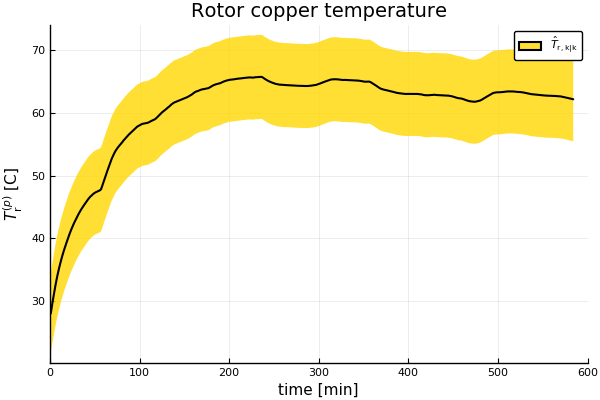

In [407]:
fx1_po = plot()
plot!(fx1_po,xu_po[1,:],ribbon=(xu_po_s[1,:]),fc=:gold,fa=0.8,lc=:black,lw=LW2,label=L"\hat{T}_\mathrm{r,k|k}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{r}^{(p)}$ [C]")
Trest=plot!(xlim=(0,600),title="Rotor copper temperature")

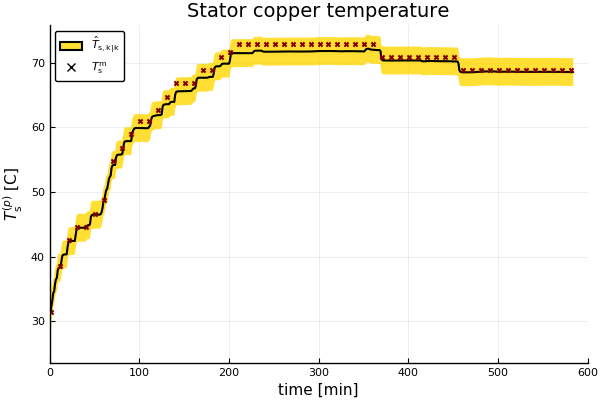

In [408]:
fx2_po = plot()
#for p in 1:np
    #plot!(fx2_po,XX_po[2,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
#end
plot!(fx2_po,xu_po[2,:],lc=:black,lw=LW2,ribbon=(xu_po_s[2,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{s,k|k}")
plot!(fx2_po,idx,Ts_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{s}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{s}^{(p)}$ [C]")
Tsest=plot!(xlim=(0,600),title="Stator copper temperature")

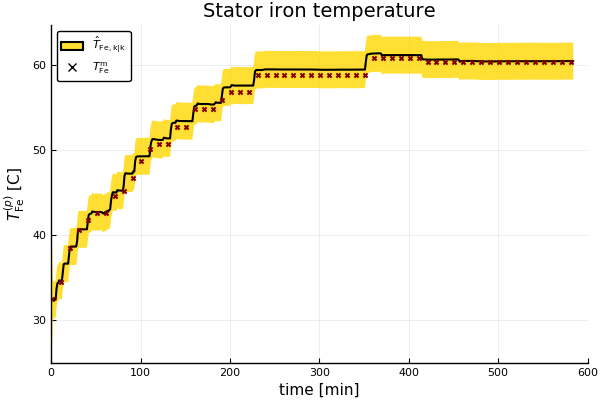

In [409]:
fx2_po = plot()
#for p in 1:np
    #plot!(fx2_po,XX_po[2,:,p],lc=:lightgray,lw=LW1,ls=LS2,label="")
#end
plot!(fx2_po,xu_po[3,:],lc=:black,lw=LW2,ribbon=(xu_po_s[3,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{Fe,k|k}")
plot!(fx2_po,idx,TFe_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{Fe}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{Fe}^{(p)}$ [C]")
TFeest=plot!(xlim=(0,600),title="Stator iron temperature")

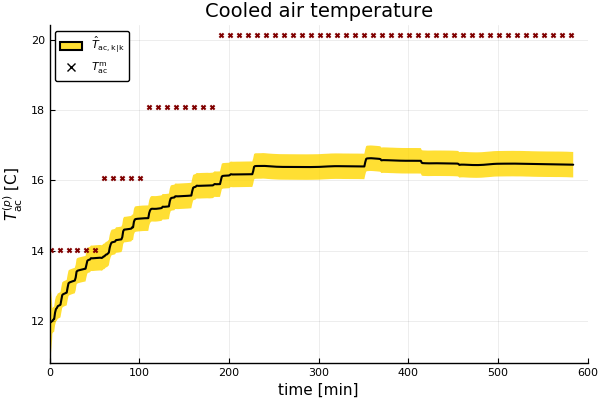

In [410]:
fz1_po = plot()
plot!(fz1_po,zu[1,:],lc=:black,lw=LW2,ribbon=(zu_s[1,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{ac,k|k}")
plot!(fz1_po,idx,Tac_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{ac}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{ac}^{(p)}$ [C]")
Tacest=plot!(xlim=(0,600),title="Cooled air temperature")

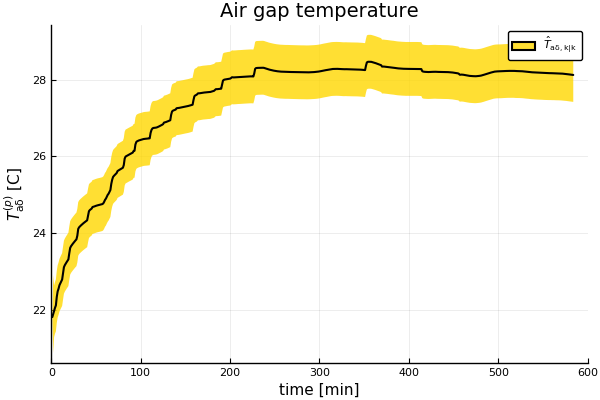

In [411]:
fz2_po = plot()
plot!(fz2_po,zu[2,:],lc=:black,lw=LW2,ribbon=(zu_s[2,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{a\delta,k|k}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{a\delta}^{(p)}$ [C]")
Tadest=plot!(xlim=(0,600),title="Air gap temperature")

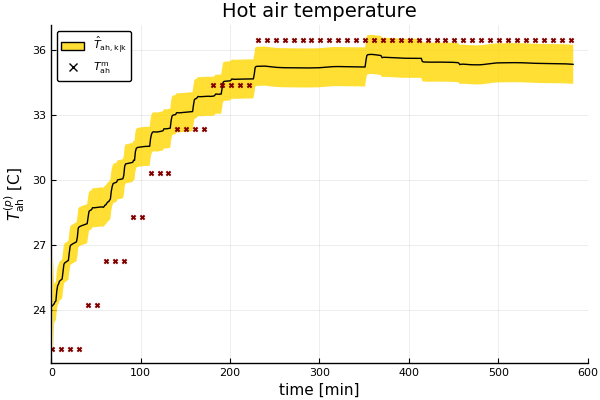

In [412]:
fz3_po = plot()
plot!(fz3_po,zu[3,:],lc=:black,ribbon=(zu_s[3,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{ah,k|k}")
plot!(fz3_po,idx,Tah_m[idx],st=:scatter,m=:x,ms=3,mc=:maroon,ma=1,label=L"T_\mathrm{ah}^{\mathrm{m}}")
plot!(xlabel="time [min]",ylabel=L"$T_\mathrm{ah}^{(p)}$ [C]")
Tahest=plot!(xlim=(0,600),title="Hot air temperature")

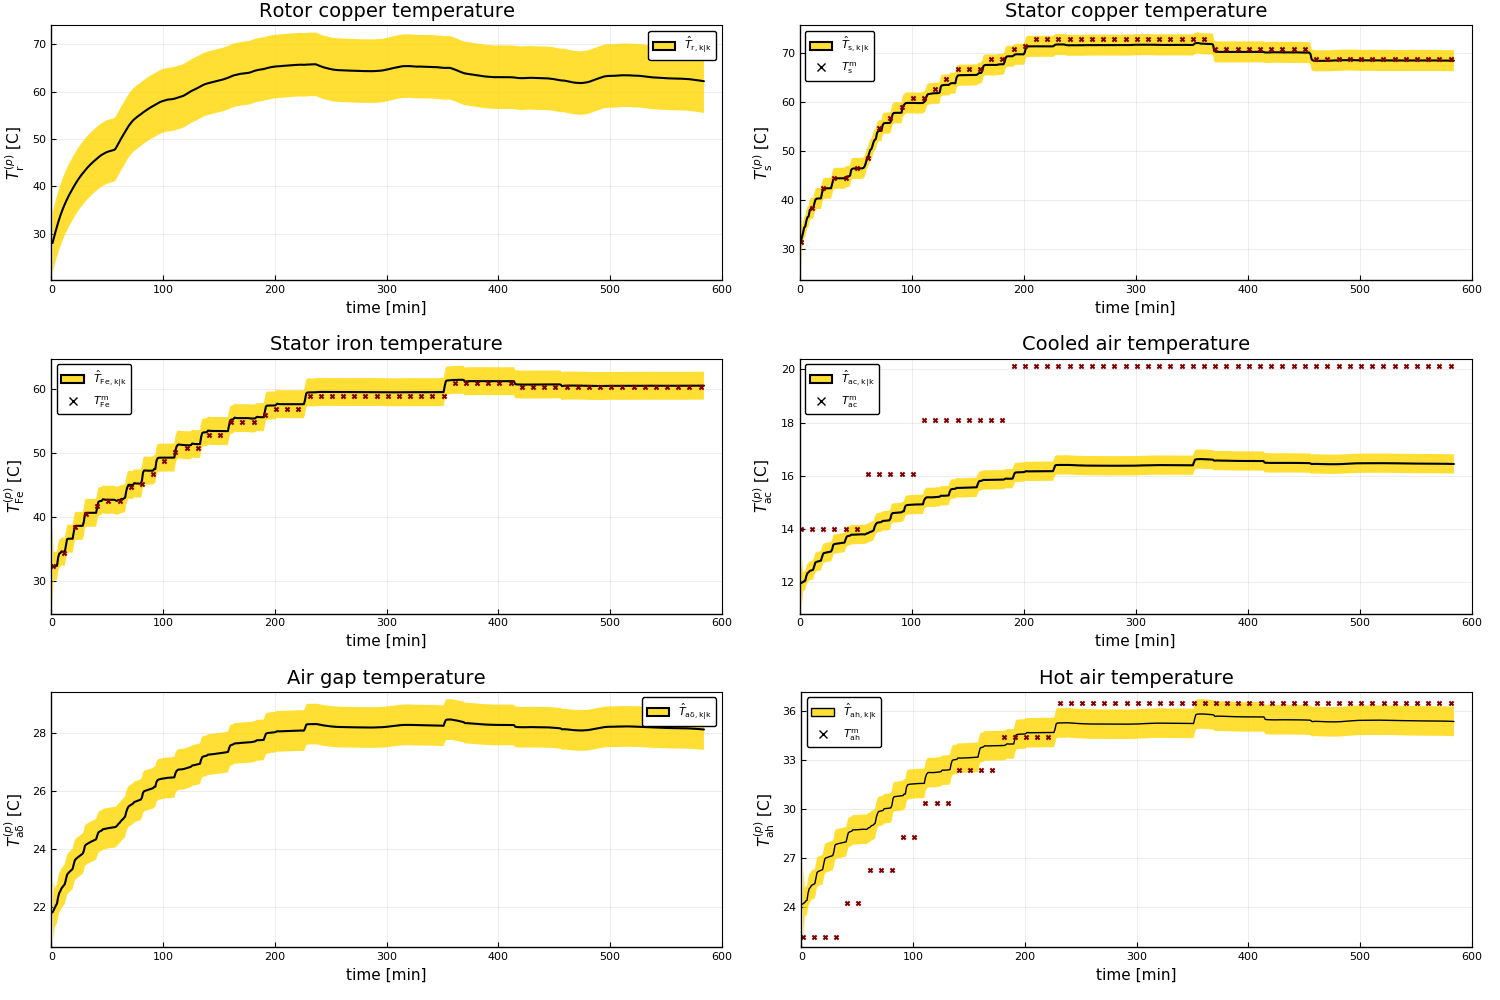

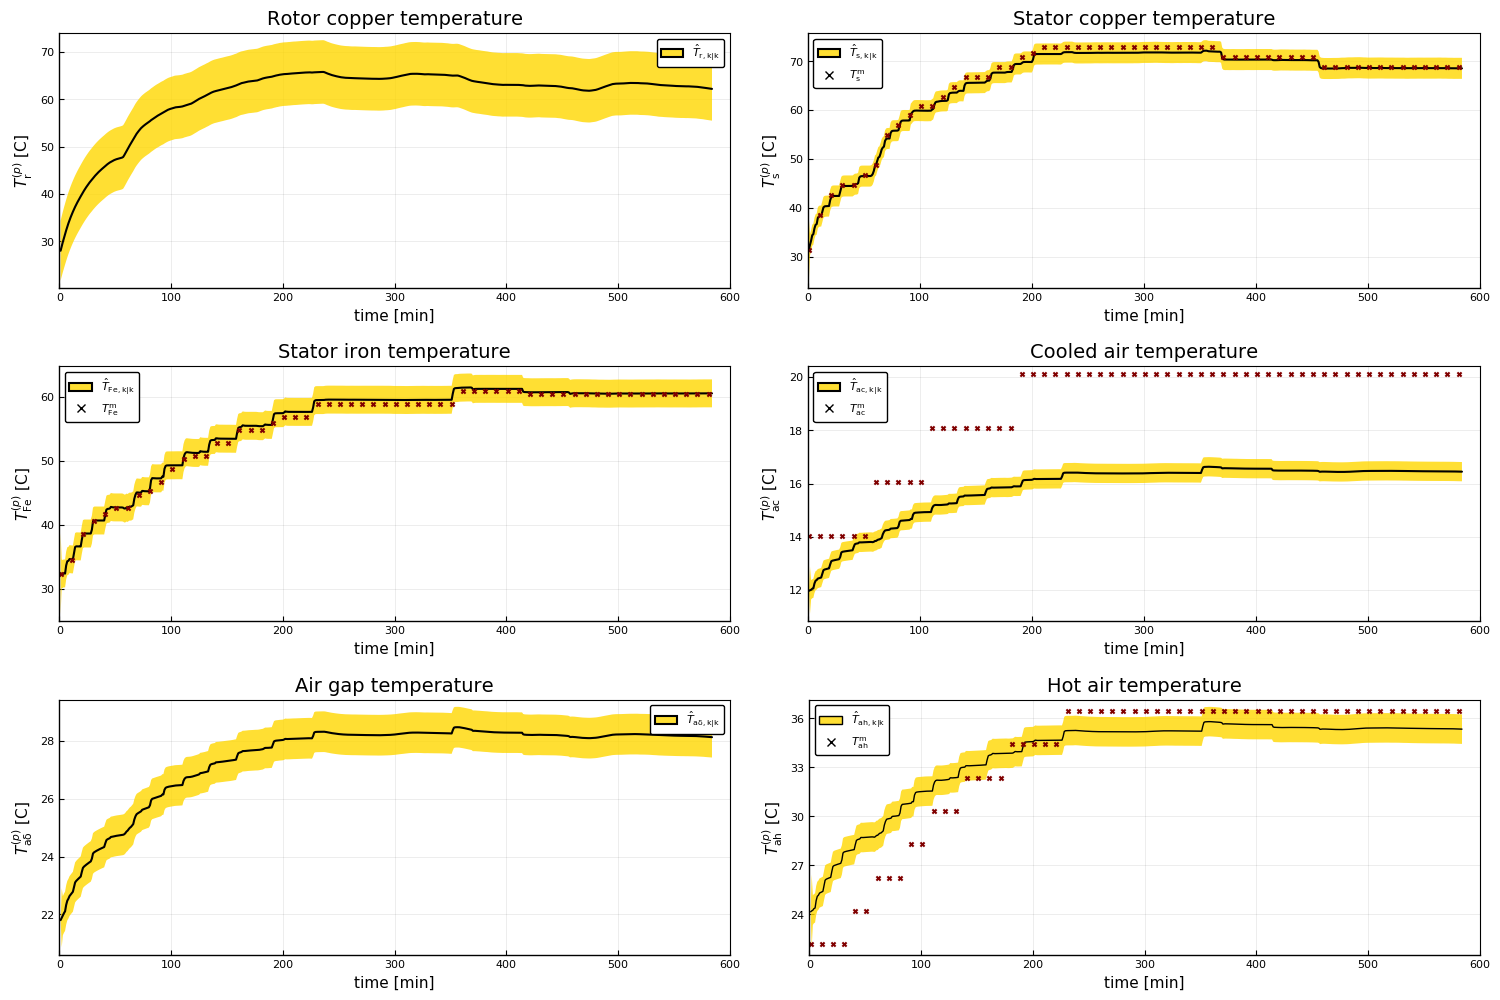

In [413]:
using Plots.PlotMeasures
plotfigure=plot(Trest, Tsest, TFeest, Tacest, Tadest, Tahest,layout=grid(3,2),size = (1500, 1000),framestyle = :box,
        bottom_margin=5mm,right_margin=5mm);
display(plotfigure)

In [58]:
# Particle filters
# Storing array and initializations
# Number of particles np; N measurement data, nx states, nz algebraic variables, ny measurements
np = 50
XX_pr = zeros(nx,N,np) # Priori particles
XX_po = zeros(nx,N,np) # Posteriori particles
ZZ = zeros(nz,N,np) # Best (posteriori) algebraic particles 
YY_pr = zeros(ny,N,np) # Priori output particles
LH = zeros(ny,N,np) # Likelihood
#
# Initialization
#
# Drawing initial state for particles
XX_po[:,1,:] = kron(x1,ones(1,np)) + sX1*randn(nx,np)
XX_pr = XX_po
#
# Computing initial algebraic variables for particles
ZZ[:,1,:] = reduce(hcat,[z_k(XX_po[:,1,p],1) for p in 1:np])
#
# Computing initial noisy outputs for particles
YY_pr[:,1,:] = reduce(hcat,[y_k(XX_pr[:,1,p]) for p in 1:np]) + sV*randn(ny,np);
#
# Computing initial likelihood
#LH[:,1,:] = 1/sqrt(2*3.14*V)*exp(-(y_m[1]-YY_pr[:,1,:])^2/2/V)

DimensionMismatch: DimensionMismatch("A has dimensions (4,4) but B has dimensions (2,50)")

In [ ]:
# Particle filter algorithm
for k in 2:N
    # predicting states for every particles
    # -- a priori --
    for p in 1:np
        XX_pr[:,k,p] = x_kp1(XX_po[:,k-1,p],ZZ[:,k-1,p],sW*randn(nx),k-1)
    end
    # Predicting outputs for every particle
    YY_pr[:,k,:] = reduce(hcat,[y_k(XX_pr[:,k,p]) for p in 1:np]) + sV*randn(ny,np);
    # Computing Likelihood of each particles conditioned on measurement y_m
    for p in 1:np
        Inn = y_m[k]- YY_pr[:,k,p]
        LH[:,k,p] = 1/sqrt(2*3.14*V)*exp(Inn^2/2/V)
    end
    # Normalizing the likelihood of a priori estimates 
    LH[:,k,:] = LH[:,k,:]/sum(LH[:,k,:])
    # Posteriori particle--resampling
    # page 467, dan simon optimal state estimation
    for i in 1:np
        randNum = rand() # between 0 and 1
        LHAcuum = 0
        for j in 1:np
            LHAccum = LHAccum + LH[:,k,j]
            if LHAccum >= randNum
                XX_po[:,k,i] = XX_pr[:,k,j]
                break 
            end
        end
    end
    # Updating algebraic variables for every particle
    ZZ[:,k,:] = reduce(hcat,[z_k(XX_po[:,k,p],k) for p in 1:np])
end

In [9]:
# Mean and standard deviations
x_pr = mean(XX_pr,dims=3)[:,:,1]
x_pr_s = std(XX_pr,dims=3)[:,:,1]
x_po = mean(XX_po,dims=3)[:,:,1]
x_po_s = std(XX_po,dims=3)[:,:,1]
z = mean(ZZ,dims=3)[:,:,1]
z_s = std(ZZ,dims=3)[:,:,1]
y_pr = mean(YY_pr,dims=3)[:,:,1];
y_pr_s = std(YY_pr,dims=3)[:,:,1];
# Plotting
fx1_po = plot()
for p in 1:np
    plot!(fx1_po,XX_po[1,:,p],lw=LW1,ls=LS2,c=:lightgray,label="")
end
plot!(fx1_po,x_po[1,:],lc=:black,lw=LW2,ribbon=(x_po_s[1,:]),fc=:gold,fa=0.8,label=L"\hat{T}_\mathrm{r,k|k}")
plot!(fx1_po,xlabel="time [min]",ylabel=L"$T_\mathrm{r}^{(p)}$ [C]")
plot!(fx1_po,xlim=(0,600),title="Rotor copper temperature")

5×5×10 Array{Float64,3}:
[:, :, 1] =
  0.0276397  0.0  0.0  0.0  0.0
  0.247376   0.0  0.0  0.0  0.0
 -0.136552   0.0  0.0  0.0  0.0
  0.0351467  0.0  0.0  0.0  0.0
  0.108008   0.0  0.0  0.0  0.0

[:, :, 2] =
  0.0684638  0.0  0.0  0.0  0.0
 -0.0907226  0.0  0.0  0.0  0.0
  0.0566014  0.0  0.0  0.0  0.0
 -0.0930187  0.0  0.0  0.0  0.0
 -0.0311953  0.0  0.0  0.0  0.0

[:, :, 3] =
 -0.142634   0.0  0.0  0.0  0.0
  0.251626   0.0  0.0  0.0  0.0
  0.0570507  0.0  0.0  0.0  0.0
 -0.0399784  0.0  0.0  0.0  0.0
  0.0723303  0.0  0.0  0.0  0.0

[:, :, 4] =
  0.0744498  0.0  0.0  0.0  0.0
 -0.0491889  0.0  0.0  0.0  0.0
  0.139505   0.0  0.0  0.0  0.0
 -0.0139326  0.0  0.0  0.0  0.0
 -0.184015   0.0  0.0  0.0  0.0

[:, :, 5] =
  0.106785    0.0  0.0  0.0  0.0
 -0.0767712   0.0  0.0  0.0  0.0
  0.13184     0.0  0.0  0.0  0.0
  0.00254513  0.0  0.0  0.0  0.0
 -0.115402    0.0  0.0  0.0  0.0

[:, :, 6] =
 -0.0868636   0.0  0.0  0.0  0.0
  0.00415962  0.0  0.0  0.0  0.0
  0.174114    0.0  0.0  0.0

In [15]:
rand(5,1)

5×1 Array{Float64,2}:
 0.8151954975283233 
 0.9670028003395972 
 0.42394444482334537
 0.8122500490404778 
 0.5099205614393467 